In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def _generate_signature_matrix_gpu(numhash, numband, bandwidth, data):
    import pycuda.autoinit
    import pycuda.driver as cuda
    from pycuda.compiler import SourceModule
    from pycuda import gpuarray
    mod = SourceModule("""
    #include<stdio.h>
    #define A 63689
    #define B 378551
    typedef unsigned int uint;
    __device__ uint hash_fn(uint key, uint seed){
        return (A * B * (key + seed + 1)) & 0x7FFFFFFF;
    }

    __global__ void generate_signature_matrix_gpu(
        uint* signature_matrix, int numhash,
        uint* data, int nrow, int ncol){
        // c.f., https://devblogs.nvidia.com/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/
        // for (int col = blockIdx.x * blockDim.x + threadIdx.x; 
        //     col < ncol; 
        //     col += blockDim.x * gridDim.x){
        for (int col = 0; col < ncol; col++){
            // MinHash Start
            uint hash_ = UINT_MAX;
            uint minhash_word = 0;
            uint current_min = hash_;
            for (int idx = 0; idx < numhash; idx++){
                for (int row = 0; row < nrow; row++){
                    // calcurate minhash
                    int pos_data = row * nrow + col;
                    if (data[pos_data] != 0){
                        hash_ = hash_fn(data[pos_data], idx);
                        if (hash_ < current_min){
                            minhash_word = data[pos_data];
                            current_min = hash_;
                        }
                    }
                    if (hash_ == UINT_MAX) minhash_word = hash_fn(3511 * col, idx);
                    // MinHash end
                    signature_matrix[idx * numhash + col] = minhash_word;
                }
            }
        }
    }
    """)
    sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
    sm_gpu = gpuarray.to_gpu(sm)
    data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
    block = (1024, 1, 1)
    grid = (2, 1, 1)
    cuda_kernel = mod.get_function("generate_signature_matrix_gpu")
    cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)
    return sm_gpu.get()

In [48]:
mh = MinHash(20, 5)
size = int(1e+03)
data = np.random.randint(0, 1, size=size**2).reshape(size, size)
sm_cpu =  generate_signature_matrix(mh, data, mode="cpu")
sm_gpu =  generate_signature_matrix(mh, data, mode="gpu")

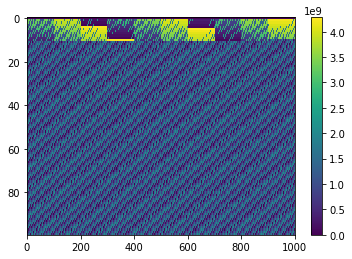

In [49]:
plt.imshow(sm_cpu - sm_gpu, aspect = "auto")
plt.colorbar()

In [46]:
sm_cpu

array([[ 487214511, 1700378824,  766059489, ...,  978740748,   44421413,
        1257585726],
       [ 974429022,   40109687, 1253274000, ..., 1465955259,  531635924,
        1744800237],
       [1461643533,  527324198, 1740488511, ..., 1953169770, 1018850435,
          84531100],
       ..., 
       [ 502381822, 1715546135,  781226800, ...,  993908059,   59588724,
        1272753037],
       [ 989596333,   55276998, 1268441311, ..., 1481122570,  546803235,
        1759967548],
       [1476810844,  542491509, 1755655822, ..., 1968337081, 1034017746,
          99698411]], dtype=uint32)

In [44]:
sm_gpu

array([[ 487214511, 1700378824,  766059489, ...,  978740748,   44421413,
        1257585726],
       [1900617538,  966298203,   31978868, ..., 1555918562,  621599227,
        1834763540],
       [ 330311704, 1543476017,  609156682, ..., 2133096376, 1198777041,
         264457706],
       ..., 
       [         0,          0,          0, ...,          0,          0,
                 0],
       [         0,          0,          0, ...,          0,          0,
                 0],
       [         0,          0,          0, ...,          0,          0,
                 0]], dtype=uint32)

In [12]:
mod = SourceModule("""
#include<stdio.h>
#define A 63689
#define B 378551
typedef unsigned int uint;
__device__ uint hash_fn(uint key, uint seed){
    return (A * B * (key + seed + 1)) & 0x7FFFFFFF;
}

__global__ void generate_signature_matrix_gpu(
    uint* signature_matrix, int numhash,
    uint* data, int nrow, int ncol){
    // c.f., https://devblogs.nvidia.com/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/
     for (int col = blockIdx.x * blockDim.x + threadIdx.x; 
         col < ncol; 
         col += blockDim.x * gridDim.x){
    // for (int col = 0; col < ncol; col++){
        // MinHash Start
        uint hash_ = UINT_MAX;
        uint minhash_word = 0;
        uint current_min = hash_;
        for (int idx = 0; idx < numhash; idx++){
            for (int row = 0; row < nrow; row++){
                // calcurate minhash
                int pos_data = row * nrow + col;
                if (data[pos_data] != 0){
                    hash_ = hash_fn(data[pos_data], idx);
                    if (hash_ < current_min){
                        minhash_word = data[pos_data];
                        current_min = hash_;
                    }
                }
                if (hash_ == UINT_MAX) minhash_word = hash_fn(3511 * col, idx);
                // MinHash end
                signature_matrix[idx * numhash + col] = minhash_word;
            }
        }
    }
}
""")


In [21]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from pycuda import gpuarray
sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
sm_gpu = gpuarray.to_gpu(sm)
data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
block   = (1024, 1, 1)                       # Block size (後述) 
grid    = (1, 1, 1)                      # Grid size (後述)
cuda_kernel = mod.get_function("generate_signature_matrix_gpu")  # 上で定義したカーネルを呼び出す
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [22]:
sm_gpu

array([[ 487214511, 1700378824,  766059489, ...,  142515535, 1355679848,
         421360513],
       [1064392325,  130072990, 1343237303, ...,  719693349, 1932857662,
         998538327],
       [1641570139,  707250804, 1920415117, ..., 1296871163,  362551828,
        1575716141],
       ..., 
       [         0,          0,          0, ...,          0,          0,
                 0],
       [         0,          0,          0, ...,          0,          0,
                 0],
       [         0,          0,          0, ...,          0,          0,
                 0]], dtype=uint32)

In [23]:
sm_cpu =  generate_signature_matrix(mh, data)

In [16]:
sm_cpu

array([[ 487214511, 1700378824,  766059489, ...,  978740748,   44421413,
        1257585726],
       [ 974429022,   40109687, 1253274000, ..., 1465955259,  531635924,
        1744800237],
       [1461643533,  527324198, 1740488511, ..., 1953169770, 1018850435,
          84531100],
       ..., 
       [ 502381822, 1715546135,  781226800, ...,  993908059,   59588724,
        1272753037],
       [ 989596333,   55276998, 1268441311, ..., 1481122570,  546803235,
        1759967548],
       [1476810844,  542491509, 1755655822, ..., 1968337081, 1034017746,
          99698411]], dtype=uint32)

In [14]:
sm_cpu

array([[ 487214511, 1700378824],
       [ 974429022,   40109687]], dtype=uint32)

In [36]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from pycuda import gpuarray
mod = SourceModule("""
#include<stdio.h>
#define A 63689
#define B 378551
typedef unsigned int uint;
__device__ uint hash_fn(uint key, uint seed){
    return (A * B * (key + seed + 1)) & 0x7FFFFFFF;
}

__global__ void generate_signature_matrix_gpu(
    uint* signature_matrix, int numhash,
    uint* data, int nrow, int ncol){
    // c.f., https://devblogs.nvidia.com/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/
     for (int col = blockIdx.x * blockDim.x + threadIdx.x; 
         col < ncol; 
         col += blockDim.x * gridDim.x){
    // for (int col = 0; col < ncol; col++){
        // MinHash Start
        uint hash_ = UINT_MAX;
        uint minhash_word = 0;
        uint current_min = hash_;
        for (int idx = 0; idx < numhash; idx++){
            for (int row = 0; row < nrow; row++){
                // calcurate minhash
                int pos_data = row * nrow + col;
                if (data[pos_data] != 0){
                    hash_ = hash_fn(data[pos_data], idx);
                    if (hash_ < current_min){
                        minhash_word = data[pos_data];
                        current_min = hash_;
                    }
                }
                if (hash_ == UINT_MAX) minhash_word = hash_fn(3511 * col, idx);
                // MinHash end
                signature_matrix[idx * numhash + col] = minhash_word;
            }
        }
    }
}
""")


In [37]:
sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
sm_gpu = gpuarray.to_gpu(sm)
data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
block   = (1024, 1, 1)                       # Block size (後述) 
grid    = (1, 1, 1)                      # Grid size (後述)
cuda_kernel = mod.get_function("generate_signature_matrix_gpu")  # 上で定義したカーネルを呼び出す
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [ ]:
mh = MinHash(20, 5)
size = int(1e+05)
data = np.random.randint(0, 1, size=size**2).reshape(size, size)

In [ ]:
%%timeit
generate_signature_matrix(mh, data)

In [ ]:
%%timeit
sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
sm_gpu = gpuarray.to_gpu(sm)
data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
block   = (1024, 1, 1)                       # Block size (後述) 
grid    = (2, 1, 1)                      # Grid size (後述)
cuda_kernel = mod.get_function("generate_signature_matrix_gpu")  # 上で定義したカーネルを呼び出す
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [ ]:
        
def rshash(key, seed = 0):
    """
    Robert Sedgewick's hashing algorithm
    """
    a = 63689
    b = 378551
    hash_ = 0
    for i in range(len(key)):
        hash_ = hash_ * a + key[i] + seed
        a = a * b
    return hash_ & 0x7FFFFFFF


In [29]:
42.6*1000 / 486

87.65432098765432

In [27]:
%%timeit
sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
sm_gpu = gpuarray.to_gpu(sm)
data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
block   = (1024, 1, 1)                       # Block size (後述) 
grid    = (1, 1, 1)                      # Grid size (後述)
cuda_kernel = mod.get_function("generate_signature_matrix_gpu")  # 上で定義したカーネルを呼び出す
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

487 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
sm = np.zeros((mh.numhash, data.shape[1]), dtype = np.uint32)
sm_gpu = gpuarray.to_gpu(sm)
data_gpu = gpuarray.to_gpu(data.astype(np.uint32))
block   = (512, 2, 1)                       # Block size (後述) 
grid    = (2, 1, 1)                      # Grid size (後述)
cuda_kernel = mod.get_function("generate_signature_matrix_gpu")  # 上で定義したカーネルを呼び出す
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data_gpu,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

486 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
data

array([[ 0.,  0.],
       [ 0.,  0.]])

In [155]:
sm_gpu

array([[ 487214511, 1700378824],
       [ 974429022,   40109687]], dtype=uint32)

In [156]:
sm_cpu

array([[ 487214511, 1700378824],
       [ 974429022,   40109687]], dtype=uint32)

In [102]:
sm_cpu.shape

(2, 2)

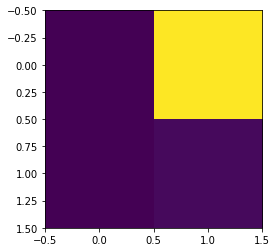

In [103]:
plt.imshow(sm_gpu.get())

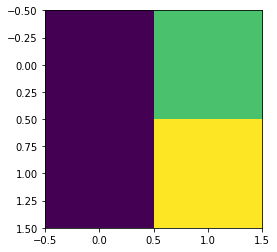

In [104]:
plt.imshow(sm_cpu)

In [85]:
sm_cpu

array([[         0, 1213164313],
       [         0, 1700378824]], dtype=uint32)

In [86]:
sm_gpu

array([[         1, 1700378824],
       [         1,   40109687]], dtype=uint32)

In [33]:
sm_cpu[0, 0]

0.0

In [ ]:
__device__ uint minhash(uint* words, int wordsize, uint seed){
    uint hash_ = hash_fn(words[0], seed);
    uint minhash_word = words[0];
    uint current_min = hash_;
    printf("%u, hash: %u \\n", 0, hash_);
    for(int i = 1; i < wordsize; i++){
        hash_ = hash_fn(words[i], seed);
        printf("%u, hash: %u \\n", i, hash_);
        printf("%d, Word %d, \\n", i, words[i]);
        // printf("Current min: %d, Hash: %d ", current_min, hash_);
        if (hash_ < current_min){
            minhash_word = words[i];
            current_min = hash_;
        }
    }
    printf("minhash_word: %d \\n", minhash_word);
    return minhash_word;
}
__global__ void testminhash(uint* ret, uint* words, int wordsize, uint seed){
    printf("calc start %d\\n", seed);
    ret[0] = minhash(words, wordsize, seed);
}



In [ ]:
cuda_kernel(sm_gpu,
            np.int32(mh.numhash),
            data,
            np.int32(data.shape[0]),
            np.int32(data.shape[1]),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [22]:
cuda_kernel = mod.get_function("testminhash")  # 上で定義したカーネルを呼び出す

In [23]:
ret = np.array([0], dtype = np.uint8)
ret_gpu = gpuarray.to_gpu(ret)
words = np.array([2, 5, 3])
seed = 58
block   = (1, 1, 1)                       # Block size (後述) 
grid    = (1, 1, 1)                      # Grid size (後述)
cuda_kernel(ret_gpu,
            cuda.InOut(np.uint32(words)),
            np.int32(len(words)),
            np.uint32(seed),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [246]:
cuda_kernel = mod.get_function("getwords")  # 上で定義したカーネルを呼び出す
block   = (1, 1, 1)                         # Block size (後述) 
grid    = (1, 1, 1)                         # Grid size (後述)
arr = np.array([0, 1, 0, 1, 0])
ret_gpu = gpuarray.to_gpu(ret)
cuda_kernel(cuda.InOut(np.uint32(arr)),
            np.int32(len(arr)),
            block=block, grid=grid)         # BlockとGridも引数として与える

In [242]:
ret_gpu.get()

array([3], dtype=uint8)

In [ ]:
"""
__global__ void generate_signature_matrix(uint key, uint seed)
{
    int pos_y = threadIdx.y + blockDim.y * blockIdx.y; // 画像のy方向の位置を取得。
    int pos_x = threadIdx.x + blockDim.x * blockIdx.x; // 画像のx方向の位置を取得。
    int idx = pos_y * height + pos_x; // 内部では1次元配列化しているので、インデックスはこのようになる

    image[idx] = 255 - image[idx];  //画素値を反転
}

"""







In [135]:
mh = MinHash(2, 4)

In [136]:
sm = generate_signature_matrix(mh, a)

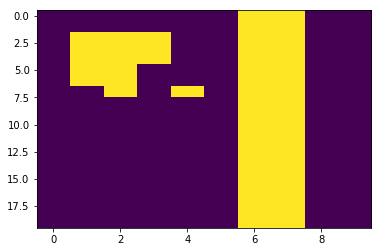

In [137]:
plt.imshow(a, aspect = "auto")

In [138]:
a.shape, sm.shape

((20, 10), (8, 10))

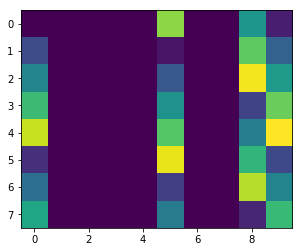

In [139]:
plt.imshow(sm)

In [54]:
np.random.randint(0, np.typema)

0

In [51]:
np.where(a[:, 1] >= 1)[0]

array([2, 3, 4, 5, 6])

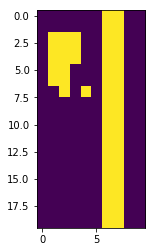

In [46]:
a = np.zeros((20, 10))
a[2:7, 1] = 1
a[2:8, 2] = 1
a[2:5, 3] = 1
a[7:8, 4] = 1
a[:, 6] = 1
a[:, 7] = 1
plt.imshow(a)

In [38]:
raise RuntimeError 'Option must be eather cpu or gpu'

SyntaxError: invalid syntax (<ipython-input-38-45363365c89e>, line 1)

In [ ]:
np.arange()

In [40]:
raise RuntimeError('Option must be eather cpu or gpu')

RuntimeError: Option must be eather cpu or gpu.

In [41]:
1/0

ZeroDivisionError: division by zero

In [21]:
hash_(1
     )

487214511

In [22]:
hash_(2)

974429022

In [23]:
hash_(3)

1461643533

In [32]:
hash_(5)

288588907

In [24]:
hash_(4)

1948858044

In [25]:
hash_(5)

288588907

In [ ]:
rshash(np.arange(10))